<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 38

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from zipfile import ZipFile
import requests
import io
import torch
import torch.nn as nn

c:\Users\Adil\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [91]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [147]:
np.min(positions_valid)

-20.379586856938328

In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [79]:
## THIS IS HOW THE DATASET CLASS WORKS
## WE RESHAPE TO 3 DIMENSIONS
## WHEN ITS (1, 2, 5) WE HAVE 2 LISTS
## THE FIRST LIST IS THE X COORDINATE FOR [PTXD1, PTXD2, ...]
## ETC. SECOND FOR Y COORDINATE, WE DOUBLE THE CHARGES SO THERES A CHARGE FOR X AND Y AND IT HAS
## THE FORM (1, 2, 5)

## LAST TENSOR HAS 6, 2 , 5 DIMENSION
## FIRST TWO FOR VELOCITIES (X, Y), 3 AND 4 FOR CHARGES AND 5 AND 6 FOR POSITIONS
print(positions_train.shape)
print(velocities_train.shape)
print(charges_train.shape)
x_1 = velocities_train[0][0] #t=0 by default
x_1 = x_1.reshape(1, 2, 5)
x_2 = charges_train #t=0 by default
x_2 = x_2.reshape(-1, 1, 5) # reshape from 128, 5, 1 -> 128, 1, 5
x_2 = torch.tensor(x_2)
x_1 = torch.tensor(x_1)
x_2 = x_2.repeat(1, 2, 1) # 128, 2, 5
x_2 = x_2[0].reshape(1, 2, 5)
x_3 = torch.tensor(positions_train)
x_3 = x_3[0, 0].view(1,2,5) # input pos of t=0
reshaped_array = torch.cat([x_1, x_2, x_3], dim=1)
print(reshaped_array)
print(np.max(positions_test))

(10000, 4, 2, 5)
(10000, 1, 2, 5)
(10000, 5, 1)
tensor([[[-0.7878,  1.5892, -1.2906, -1.9173,  0.6539],
         [ 0.0267, -0.4211,  2.3834, -0.5785, -0.5676],
         [-1.0000,  1.0000,  1.0000,  1.0000, -1.0000],
         [-1.0000,  1.0000,  1.0000,  1.0000, -1.0000],
         [-1.9361,  3.6532, -4.5496, -3.0958,  0.1073],
         [-0.2276, -2.7631,  8.2998, -3.0921, -2.8976]]], dtype=torch.float64)
19.441097754465503


In [6]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [7]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

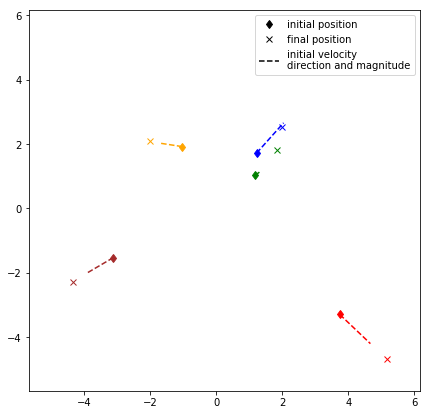

In [8]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [9]:
import itertools
"""
Get all lists of indices to shuffle the train set
"""
def shuffle_indices(indices):

    comb_list = []
    for x in itertools.permutations(indices):
        comb_list.append(list(x))
    return comb_list

list_indices = shuffle_indices(indices = [0, 1, 2, 3, 4])
print(len(list_indices))

120


In [144]:
tensor = torch.rand(1, 2, 5)
tensor

tensor([[[0.7859, 0.9596, 0.0972, 0.8639, 0.3707],
         [0.0672, 0.2163, 0.2450, 0.2633, 0.9810]]])

In [10]:
"""
Shuffle the train set such that we move
each particle to a different location
such that the model is permutation invariant
"""
# too difficult to implement 

for sim in range(positions_train.shape[0]):
    for i in list_indices[:10]:
        # print(positions_train[sim])
        # print("\n")
        # print(np.transpose(positions_train[sim, :, :, i]))
        break
    break   
        
# normalize by just dividing
# check labels and predictions

In [11]:
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch.nn.functional import normalize
class MyDataset(Dataset):

    """
    :Input data: velocity, charges and positions array of dimensions:
            (simulations, 4, 2, 5), positions at 4 time points for 2 spatial dimensions and 5 particles
            (simulations, 1, 2, 5), velocities at 1 time point for 2 spatial dimensions and 5 particles
            (simulations, 5, 1), charges for 5 time points for 1 spatial dimension (x, and y combined)
    :output data:
            x: (batchsize, 6, 2, 5), positions, velocities and charges at 6 time points for 2 spatial dimensions and 5 particles
            y: (batchsize, 1, 2, 5), position at 1 time point for 2 spatial dimensions and 5 particles 
    """
    def __init__(self, veloc, pos, charges,time_id, norm, transform=None):
        self.velocity = torch.FloatTensor(veloc)
        self.charges = torch.FloatTensor(charges)
        self.position = torch.FloatTensor(pos)
        self.time_id = time_id
        self.norm = norm
        self.transform = transform

    def __getitem__(self, index):
        x_1 = self.velocity[index] #t=0 by default
        x_2 = self.charges[index] #t=0 by default
        x_2 = x_2.reshape(-1, 1, 5) # reshape from 128, 5, 1 -> 128, 1, 5
        x_2 = x_2.repeat(1, 2, 1) # 128, 2, 5 so we get charges for x and y
        x_3 = self.position[index, 0].view(1,2,5) # because we only want position at time 0
        reshaped_array = torch.cat([x_1, x_2, x_3], dim=1)
        y = self.position[index, self.time_id].view(1,2,5) # output pos of t=time_id

        if self.norm is not False:
            reshaped_array = normalize(reshaped_array)
            y = normalize(y)
        
        if self.transform is not None:
            reshaped_array = self.transform(reshaped_array)
            y = self.transform(y)

        return reshaped_array, y

    def __len__(self):
        return len(self.charges)

# Model Implementation

In [107]:
# Simple NN network for value prediction
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
class SimpleModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 10)
        # self.layer5 = nn.Linear(32, 10)
        self.norm1 = nn.BatchNorm1d(32)
        self.norm2 = nn.BatchNorm1d(64)
        self.norm3 = nn.BatchNorm1d(10)
        self.drop = nn.Dropout(0.2)
        
        
    def forward(self, x):
        x = self.norm1(F.relu(self.layer1(x)))
        x = self.drop(x)
        x = self.norm2(F.relu(self.layer2(x)))
        x = self.drop(x)
        x = self.norm2(F.relu(self.layer3(x)))
        x = self.drop(x)
        x = self.norm3(F.relu(self.layer4(x)))
        # x = F.relu(self.layer4(x))
        # x = F.relu(self.layer5(x))
        # x = self.drop(x)
        return x

# Model Training

In [108]:
# saving and loading checkpoint mechanisms 
# modules adapted from https://github.com/ttchengab/One_Shot_Pytorch/blob/master/network.ipynb
from varname import argname
def save_checkpoint(save_path, model, optimizer, val_loss):
  """
  Utility function for saving the model 

  Input
    --save_path: path to save the model
    --model: model to be saved
    --optimizer: optimizer to be saved
    --val_loss: lowest validation loss so far

  Output
    Saved model as pt file
  """
  if save_path==None:
      return
  save_path = save_path 
  state_dict = {'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss}

  torch.save(state_dict, save_path)
  print(f'Model saved to ==> {save_path}')


def load_checkpoint(model, optimizer, save_path):
  """
  Utility function to load a saved model
  Input
    --model: model object to load the weights into
    --optimizer: optimizer object
    
  Output:
    Validation loss
  """
  # save_path = f'SiameseNetwork.pt'
  state_dict = torch.load(save_path)
  model.load_state_dict(state_dict['model_state_dict'])
  optimizer.load_state_dict(state_dict['optimizer_state_dict'])
  val_loss = state_dict['val_loss']
  print(f'Model loaded from <== {save_path}')
  
  return val_loss

In [109]:
# NN MODEL
from tqdm import tqdm
def train(model, train_loader, val_loader, n_epochs, optimizer, criterion, save_name):
    train_losses = []
    val_losses = []
    best_val_loss = float("Inf")
    for _ in range(1, n_epochs + 1):
        model.train()

        for x, y in tqdm(train_loader):
            y = y.view(y.shape[0], 10) # first 5 values in this tensor are x pos coordinates last 5 are y  pos coordinates         
            x = x.view(x.shape[0], 30) # first 0-5 x veloc, 5-10 y veloc, 10-15 charges, 15-20 y charges, 20-25 x pos, 25-30 y pos         
            batch_loss = 0.0
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            batch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        avg_train_loss = batch_loss / len(train_loader) # batch size
        train_losses.append(avg_train_loss)

        with torch.no_grad():
            model.eval()
            for x, y in val_loader:
                y = y.view(y.shape[0], 10)
                x = x.view(x.shape[0], 30)
                val_batch_loss = 0.0
                outputs = model(x)
                # output_val.append(outputs)
                loss = criterion(outputs, y)
                val_batch_loss += loss.item()

        avg_val_loss = val_batch_loss / len(val_loader) # batch size
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)

    return train_losses, val_losses

In [110]:
from os import listdir
from os.path import isfile, join
from varname import nameof
learning_rate = 1e-3
weight_decay = 1e-6

# intialize models with weights and optimizers
model_10000_1 = SimpleModel(input_dim=30)
model_10000_2 = SimpleModel(input_dim=30)
model_10000_3 = SimpleModel(input_dim=30)
model_1000_1 = SimpleModel(input_dim=30)
model_1000_2 = SimpleModel(input_dim=30)
model_1000_3 = SimpleModel(input_dim=30)
model_100_1 = SimpleModel(input_dim=30)
model_100_2 = SimpleModel(input_dim=30)
model_100_3 = SimpleModel(input_dim=30)

optimizer_10000_1 = optim.Adam(model_10000_1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_10000_2 = optim.Adam(model_10000_2.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_10000_3 = optim.Adam(model_10000_3.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_1000_1  = optim.Adam(model_1000_1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_1000_2  = optim.Adam(model_1000_2.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_1000_3  = optim.Adam(model_1000_3.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_100_1  =  optim.Adam(model_100_1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_100_2 =   optim.Adam(model_100_2.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_100_3 =   optim.Adam(model_100_3.parameters(), lr=learning_rate, weight_decay=weight_decay)

models = [model_100_1, model_100_2, model_100_3, model_1000_1, model_1000_2, model_1000_3, model_10000_1, model_10000_2, model_10000_3]
optimizers = [optimizer_100_1, optimizer_100_2, optimizer_100_3, optimizer_1000_1, optimizer_1000_2, optimizer_1000_3, optimizer_10000_1, optimizer_10000_2, optimizer_10000_3]

# Checking for checkpoints to load them
model_files = [f for f in listdir("models") if isfile(join("models", f))]
if len(model_files) == len(models):
    print("loading model from models folder")
    for index, model_file in enumerate(model_files):  
        model_location = "models\\" + model_file
        load_checkpoint(models[index], optimizers[index], model_location)
    
else:
    print("No models to load, continue to train loop")

No models to load, continue to train loop


In [111]:
# SKIP THIS IF YOU'RE LOADING FROM \MODELS.
def train_loop(samples, timeids, models, optimizers, criterion):
    count = 0 # could do enumerate but lazy to do it 2x and add them/multiply them
    for sample in samples:
        for timeid in timeids:
            val_ratio = int(sample/5)
            train_dataset =MyDataset(velocities_train[:sample], positions_train[:sample], charges_train[:sample], time_id = timeid, norm = True, transform=None) 
            val_dataset = MyDataset(velocities_valid[:val_ratio], positions_valid[:val_ratio], charges_valid[:val_ratio], time_id = timeid, norm = True, transform=None) 

            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128) 
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128) 
            trainloss, valloss = train(model= models[count], train_loader= train_loader, val_loader=val_loader, n_epochs=10, optimizer= optimizers[count], criterion=criterion, save_name='models\\NN' + '_' + str(sample) + '_' + str(timeid) + '.pt')
            plt.figure()
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.plot(trainloss, label='Train Loss')
            plt.plot(valloss, label="Validation Loss")
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            plt.savefig("images\\NN" + '_' + str(sample) + '_' + str(timeid) + ".png")
            plt.show
            plt.close()
            print(count)
            count +=1
            

samples = [100, 1000, 10000]
timeids = [1, 2, 3]
learning_rate = 1e-3
weight_decay = 1e-6
loss_fn = nn.MSELoss(reduction="mean") # can do MSE/MAE depends on outliers
train_loop(samples, timeids, models, optimizers, loss_fn)

100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


Model saved to ==> models\NN_100_1.pt


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


Model saved to ==> models\NN_100_1.pt


100%|██████████| 1/1 [00:00<00:00, 62.49it/s]


Model saved to ==> models\NN_100_1.pt


100%|██████████| 1/1 [00:00<00:00, 62.49it/s]


Model saved to ==> models\NN_100_1.pt


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


Model saved to ==> models\NN_100_1.pt


100%|██████████| 1/1 [00:00<00:00, 62.48it/s]


Model saved to ==> models\NN_100_1.pt


100%|██████████| 1/1 [00:00<00:00, 62.49it/s]


Model saved to ==> models\NN_100_1.pt


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


Model saved to ==> models\NN_100_1.pt


100%|██████████| 1/1 [00:00<00:00, 58.81it/s]


Model saved to ==> models\NN_100_1.pt
0


100%|██████████| 1/1 [00:00<00:00, 62.48it/s]


Model saved to ==> models\NN_100_2.pt


100%|██████████| 1/1 [00:00<00:00, 62.48it/s]


1


100%|██████████| 1/1 [00:00<00:00, 62.49it/s]


Model saved to ==> models\NN_100_3.pt


100%|██████████| 1/1 [00:00<00:00, 58.81it/s]


Model saved to ==> models\NN_100_3.pt


100%|██████████| 1/1 [00:00<00:00, 66.66it/s]


2


100%|██████████| 8/8 [00:00<00:00, 50.94it/s]


Model saved to ==> models\NN_1000_1.pt


100%|██████████| 8/8 [00:00<00:00, 50.94it/s]


Model saved to ==> models\NN_1000_1.pt


100%|██████████| 8/8 [00:00<00:00, 50.30it/s]


Model saved to ==> models\NN_1000_1.pt


100%|██████████| 8/8 [00:00<00:00, 49.07it/s]


Model saved to ==> models\NN_1000_1.pt


100%|██████████| 8/8 [00:00<00:00, 50.94it/s]


Model saved to ==> models\NN_1000_1.pt


100%|██████████| 8/8 [00:00<00:00, 53.32it/s]


Model saved to ==> models\NN_1000_1.pt


100%|██████████| 8/8 [00:00<00:00, 51.60it/s]


Model saved to ==> models\NN_1000_1.pt


100%|██████████| 8/8 [00:00<00:00, 54.04it/s]


Model saved to ==> models\NN_1000_1.pt
3


100%|██████████| 8/8 [00:00<00:00, 49.68it/s]


Model saved to ==> models\NN_1000_2.pt


100%|██████████| 8/8 [00:00<00:00, 51.60it/s]


Model saved to ==> models\NN_1000_2.pt


100%|██████████| 8/8 [00:00<00:00, 48.77it/s]


Model saved to ==> models\NN_1000_2.pt


100%|██████████| 8/8 [00:00<00:00, 51.27it/s]


Model saved to ==> models\NN_1000_2.pt


100%|██████████| 8/8 [00:00<00:00, 53.68it/s]


Model saved to ==> models\NN_1000_2.pt


100%|██████████| 8/8 [00:00<00:00, 53.32it/s]


Model saved to ==> models\NN_1000_2.pt


100%|██████████| 8/8 [00:00<00:00, 49.99it/s]


Model saved to ==> models\NN_1000_2.pt
4


100%|██████████| 8/8 [00:00<00:00, 49.99it/s]


Model saved to ==> models\NN_1000_3.pt


100%|██████████| 8/8 [00:00<00:00, 49.96it/s]


Model saved to ==> models\NN_1000_3.pt


100%|██████████| 8/8 [00:00<00:00, 53.93it/s]


Model saved to ==> models\NN_1000_3.pt


100%|██████████| 8/8 [00:00<00:00, 52.62it/s]


Model saved to ==> models\NN_1000_3.pt


100%|██████████| 8/8 [00:00<00:00, 47.61it/s]


Model saved to ==> models\NN_1000_3.pt
5


100%|██████████| 79/79 [00:01<00:00, 51.72it/s]


Model saved to ==> models\NN_10000_1.pt


100%|██████████| 79/79 [00:01<00:00, 50.73it/s]


Model saved to ==> models\NN_10000_1.pt


100%|██████████| 79/79 [00:01<00:00, 53.10it/s]


Model saved to ==> models\NN_10000_1.pt


100%|██████████| 79/79 [00:01<00:00, 51.68it/s]


Model saved to ==> models\NN_10000_1.pt


100%|██████████| 79/79 [00:01<00:00, 52.17it/s]


Model saved to ==> models\NN_10000_1.pt


100%|██████████| 79/79 [00:01<00:00, 51.12it/s]


Model saved to ==> models\NN_10000_1.pt


100%|██████████| 79/79 [00:01<00:00, 51.25it/s]


Model saved to ==> models\NN_10000_1.pt


100%|██████████| 79/79 [00:01<00:00, 43.85it/s]


Model saved to ==> models\NN_10000_1.pt


100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Model saved to ==> models\NN_10000_1.pt


100%|██████████| 79/79 [00:01<00:00, 50.15it/s]


Model saved to ==> models\NN_10000_1.pt
6


100%|██████████| 79/79 [00:01<00:00, 55.00it/s]


Model saved to ==> models\NN_10000_2.pt


100%|██████████| 79/79 [00:01<00:00, 49.32it/s]


Model saved to ==> models\NN_10000_2.pt


100%|██████████| 79/79 [00:01<00:00, 52.00it/s]


Model saved to ==> models\NN_10000_2.pt


100%|██████████| 79/79 [00:01<00:00, 52.65it/s]


Model saved to ==> models\NN_10000_2.pt


100%|██████████| 79/79 [00:01<00:00, 47.15it/s]


Model saved to ==> models\NN_10000_2.pt


100%|██████████| 79/79 [00:01<00:00, 52.31it/s]


Model saved to ==> models\NN_10000_2.pt


100%|██████████| 79/79 [00:01<00:00, 52.79it/s]


Model saved to ==> models\NN_10000_2.pt


100%|██████████| 79/79 [00:01<00:00, 51.83it/s]


Model saved to ==> models\NN_10000_2.pt


100%|██████████| 79/79 [00:01<00:00, 51.22it/s]


7


100%|██████████| 79/79 [00:01<00:00, 49.68it/s]


Model saved to ==> models\NN_10000_3.pt


100%|██████████| 79/79 [00:01<00:00, 51.76it/s]


Model saved to ==> models\NN_10000_3.pt


100%|██████████| 79/79 [00:01<00:00, 51.06it/s]


Model saved to ==> models\NN_10000_3.pt


100%|██████████| 79/79 [00:01<00:00, 50.86it/s]


Model saved to ==> models\NN_10000_3.pt


100%|██████████| 79/79 [00:01<00:00, 49.00it/s]


Model saved to ==> models\NN_10000_3.pt


100%|██████████| 79/79 [00:01<00:00, 51.19it/s]


Model saved to ==> models\NN_10000_3.pt


100%|██████████| 79/79 [00:01<00:00, 51.06it/s]


Model saved to ==> models\NN_10000_3.pt


100%|██████████| 79/79 [00:01<00:00, 50.96it/s]


Model saved to ==> models\NN_10000_3.pt


100%|██████████| 79/79 [00:01<00:00, 50.42it/s]


Model saved to ==> models\NN_10000_3.pt


100%|██████████| 79/79 [00:01<00:00, 50.46it/s]


Model saved to ==> models\NN_10000_3.pt
8


## Prediction + label

In [158]:
# GET OUR PREDICTIONS AND LABELS
from varname import nameof

from tqdm import tqdm
def test(models, testloaders):
    output_dict = dict()
    with torch.no_grad():
        models_1 = models[::3] # models for time horizon 0.5 (timeid = 1)
        models_2 = models[1::3] # models for time horizon 1 (timeid = 2)
        models_3 = models[2::3] # models for time horizon 1.5 (timeid = 3)
        outputlst = ['0', '00', '000']
        for index, model in enumerate(models_1):
            output_test = [] 
            labels = []
            model.eval()
            count = 0
            for x, y in testloaders[0]:
                y = y.view(y.shape[0], 10)# first 5 values in this tensor are x pos coordinates last 5 are y pos coordinates        
                x = x.view(x.shape[0], 30)# first 0-5 x veloc, 5-10 y veloc, 10-15 charges, 15-20 y charges, 20-25 x pos, 25-30 y pos
                outputs = model(x)
                output_test.append(outputs)
                labels.append(y)
                count += 1
            output_dict['model_10' + outputlst[index] + '_1_output'] = output_test 
            output_dict['model_10' + outputlst[index] + '_1_labels'] = labels
        for index, model in enumerate(models_2):
            output_test = [] 
            labels = []
            model.eval()
            for x, y in testloaders[1]:
                y = y.view(y.shape[0], 10)# first 5 values in this tensor are x pos coordinates last 5 are y pos coordinates        
                x = x.view(x.shape[0], 30)# first 0-5 x veloc, 5-10 y veloc, 10-15 charges, 15-20 y charges, 20-25 x pos, 25-30 y pos
                outputs = model(x)
                output_test.append(outputs)
                labels.append(y)
            output_dict['model_10' + outputlst[index] + '_2_output'] = output_test 
            output_dict['model_10' + outputlst[index] + '_2_labels'] = labels
        for index, model in enumerate(models_3):
            output_test = [] 
            labels = []
            model.eval()
            for x, y in testloaders[2]:
                y = y.view(y.shape[0], 10)# first 5 values in this tensor are x pos coordinates last 5 are y pos coordinates        
                x = x.view(x.shape[0], 30)# first 0-5 x veloc, 5-10 y veloc, 10-15 charges, 15-20 y charges, 20-25 x pos, 25-30 y pos
                outputs = model(x)
                output_test.append(outputs)
                labels.append(y)
            output_dict['model_10' + outputlst[index] + '_3_output'] = output_test 
            output_dict['model_10' + outputlst[index] + '_3_labels'] = labels
    return output_dict

In [159]:
# NOTES

# eval turns off dropouts and since we used so many regularization techniques to get a decent model we sacrifice
# train accuracy, with such low data this can have an even larger effect

# do i take a sample of validation as well?
# ITS OUTPUTTING TO WRONG PARTS 
models_str = ["model_100_1", "model_100_2", "model_100_3", "model_1000_1", "model_1000_2", "model_1000_3", "model_10000_1", "model_10000_2", "model_10000_3"]
models_str[2::3]


['model_100_3', 'model_1000_3', 'model_10000_3']

In [163]:
test_dataset_1 = MyDataset(velocities_test, positions_test, charges_test, time_id = 1, norm = True, transform=None)
test_dataset_2 = MyDataset(velocities_test, positions_test, charges_test, time_id = 2, norm = True, transform=None)
test_dataset_3 = MyDataset(velocities_test, positions_test, charges_test, time_id = 3, norm = True, transform=None)
test_loader_1 = torch.utils.data.DataLoader(test_dataset_1, batch_size=128) # len(test_dataset) = 2000
test_loader_2 = torch.utils.data.DataLoader(test_dataset_2, batch_size=128) # len(test_dataset) = 2000
test_loader_3 = torch.utils.data.DataLoader(test_dataset_3, batch_size=128) # len(test_dataset) = 2000

testloaders = [test_loader_1, test_loader_2, test_loader_3]
test_dict = test(models, testloaders)
test_dict.keys()

# Right now we return the prediction and the labels for each model

dict_keys(['model_100_1_output', 'model_100_1_labels', 'model_1000_1_output', 'model_1000_1_labels', 'model_10000_1_output', 'model_10000_1_labels', 'model_100_2_output', 'model_100_2_labels', 'model_1000_2_output', 'model_1000_2_labels', 'model_10000_2_output', 'model_10000_2_labels', 'model_100_3_output', 'model_100_3_labels', 'model_1000_3_output', 'model_1000_3_labels', 'model_10000_3_output', 'model_10000_3_labels'])

In [167]:
# append predictions and labels to list
def split_output(test_output, labels):
    test_x = []
    test_y = []
    act_x = []
    act_y = []
    for batch in test_output: # 16 batches
        arr = batch.numpy()
        for sim in range(arr.shape[0]): # for each index in batch
            y = arr[sim][5:] # last 5 predictions are y pos predictions
            x = arr[sim][:5] # take every even index
        
            test_x.extend(x)
            test_y.extend(y)
    
    for lab_batch in labels:
        arr_lab = lab_batch.numpy()
        for sim in range(arr_lab.shape[0]):
            y_lab = arr_lab[sim][5:]  # take every even index
            x_lab = arr_lab[sim][:5] # take every even index
        
            act_x.extend(x_lab)
            act_y.extend(y_lab)
    
    return test_x, test_y, act_x, act_y


In [168]:
x_pred_100_1, y_pred_100_1, x_act_100_1, y_act_100_1 = split_output(test_dict['model_100_1_output'], test_dict['model_100_1_labels'])
x_pred_100_2, y_pred_100_2, x_act_100_2, y_act_100_2 = split_output(test_dict['model_100_2_output'], test_dict['model_100_2_labels'])
x_pred_100_3, y_pred_100_3, x_act_100_3, y_act_100_3 = split_output(test_dict['model_100_3_output'], test_dict['model_100_3_labels'])
x_pred_1000_1, y_pred_1000_1, x_act_1000_1, y_act_1000_1 = split_output(test_dict['model_1000_1_output'], test_dict['model_1000_1_labels'])
x_pred_1000_2, y_pred_1000_2, x_act_1000_2, y_act_1000_2 = split_output(test_dict['model_1000_2_output'], test_dict['model_1000_2_labels'])
x_pred_1000_3, y_pred_1000_3, x_act_1000_3, y_act_1000_3 = split_output(test_dict['model_1000_3_output'], test_dict['model_1000_3_labels'])
x_pred_10000_1, y_pred_10000_1, x_act_10000_1, y_act_10000_1 = split_output(test_dict['model_10000_1_output'], test_dict['model_10000_1_labels'])
x_pred_10000_2, y_pred_10000_2, x_act_10000_2, y_act_10000_2 = split_output(test_dict['model_10000_2_output'], test_dict['model_10000_2_labels'])
x_pred_10000_3, y_pred_10000_3, x_act_10000_3, y_act_10000_3 = split_output(test_dict['model_10000_3_output'], test_dict['model_10000_3_labels'])
# labels are the same for each horizon so a bit redundant but whatever

## Baseline predictions

In [169]:
# Formala prediction
def baseline_prediction(t):
    baseline_pred_x = []
    baseline_pred_y = []
    for sim in range(2000): # should be 2000
        for ptxd in range(5):
            #x_t = x_0 + v_0 * t for (x, y)
            x_pos, y_pos = (positions_test[sim, 0, 0, ptxd]) + (velocities_test[sim, 0, 0, ptxd]*t), positions_test[sim, 0, 1, ptxd] + (velocities_test[sim, 0, 1, ptxd]*t)
            baseline_pred_x.append(x_pos)
            baseline_pred_y.append(y_pos)
    return baseline_pred_x, baseline_pred_y
# charges_test
baseline_pred_x_1, baseline_pred_y_1 = baseline_prediction(t=0.5)
baseline_pred_x_2, baseline_pred_y_2 = baseline_prediction(t=1)
baseline_pred_x_3, baseline_pred_y_3 = baseline_prediction(t=1.5)

In [175]:
from sklearn.metrics import mean_squared_error
print("The NN's MSE with sample size 100 with horizon 0.5 is: x =", mean_squared_error(x_act_100_1, x_pred_100_1),  "y =",mean_squared_error(y_act_100_1, y_pred_100_1))
print("The NN's MSE with sample size 100 with horizon 1.0 is: x =", mean_squared_error(x_act_100_2, x_pred_100_2),  "y =",mean_squared_error(y_act_100_2, y_pred_100_2))
print("The NN's MSE with sample size 100 with horizon 1.5 is: x =", mean_squared_error(x_act_100_3, x_pred_100_3),  "y =",mean_squared_error(y_act_100_3, y_pred_100_3))
print("The NN's MSE with sample size 1000 with horizon 0.5 is: x =", mean_squared_error(x_act_1000_1, x_pred_1000_1),  "y =",mean_squared_error(y_act_1000_1, y_pred_1000_1))
print("The NN's MSE with sample size 1000 with horizon 1.0 is: x =", mean_squared_error(x_act_1000_2, x_pred_1000_2),  "y =",mean_squared_error(y_act_1000_2, y_pred_1000_2))
print("The NN's MSE with sample size 1000 with horizon 1.5 is: x =", mean_squared_error(x_act_1000_3, x_pred_1000_3),  "y =",mean_squared_error(y_act_1000_3, y_pred_1000_3))
print("The NN's MSE with sample size 10000 with horizon 0.5 is: x =", mean_squared_error(x_act_10000_1, x_pred_10000_1),  "y =",mean_squared_error(y_act_10000_1, y_pred_10000_1))
print("The NN's MSE with sample size 10000 with horizon 1.0 is: x =", mean_squared_error(x_act_10000_2, x_pred_10000_2),  "y =",mean_squared_error(y_act_10000_2, y_pred_10000_2))
print("The NN's MSE with sample size 10000 with horizon 1.5 is: x =", mean_squared_error(x_act_10000_3, x_pred_10000_3),  "y =",mean_squared_error(y_act_10000_3, y_pred_10000_3))
print("\n")

print("The formula's MSE with time horizon 0.5 is: x =" ,mean_squared_error(x_act_100_1, baseline_pred_x_1), "y =", mean_squared_error(y_act_100_1, baseline_pred_y_1))
print("The formula's MSE with time horizon 1.0 is: x= " ,mean_squared_error(x_act_100_2, baseline_pred_x_2), "y =", mean_squared_error(y_act_100_2, baseline_pred_y_2))
print("The formula's MSE with time horizon 1.5 is: x =" ,mean_squared_error(x_act_100_3, baseline_pred_x_3), "y =", mean_squared_error(y_act_100_3, baseline_pred_y_3))


The NN's MSE with sample size 100 with horizon 0.5 is: x = 0.5260529 y = 0.47992992
The NN's MSE with sample size 100 with horizon 1.0 is: x = 0.5161723 y = 0.5161848
The NN's MSE with sample size 100 with horizon 1.5 is: x = 0.51144665 y = 0.5074039
The NN's MSE with sample size 1000 with horizon 0.5 is: x = 0.334233 y = 0.341655
The NN's MSE with sample size 1000 with horizon 1.0 is: x = 0.33957994 y = 0.35635704
The NN's MSE with sample size 1000 with horizon 1.5 is: x = 0.37979242 y = 0.40259326
The NN's MSE with sample size 10000 with horizon 0.5 is: x = 0.038786493 y = 0.0372379
The NN's MSE with sample size 10000 with horizon 1.0 is: x = 0.053446125 y = 0.048554882
The NN's MSE with sample size 10000 with horizon 1.5 is: x = 0.06059071 y = 0.0602058


The formula's MSE with time horizon 0.5 is: x = 4.8731730437530265 y = 4.8836007994871276
The formula's MSE with time horizon 1.0 is: x=  6.782889049402658 y = 6.77666245296252
The formula's MSE with time horizon 1.5 is: x = 9.1250

# Evaluation

In [ ]:
# fix normalize to be same
# fix data augmentation to be same

## RNN TEST

In [ ]:
# LSTmodel RNN
#####
#https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b
####
class LSTMModel(nn.Module):
    # input dim are the features which should be only 1 right t=0?
    # or is it 5 because 5 particles?
    def __init__(self, input_dim = 30 , hidden_dim = 256, layer_dim = 2, output_dim = 10, dropout_prob = 0.2):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [ ]:
# RNN MODEL
from tqdm import tqdm
def trainRNN(model, train_loader, n_epochs, optimizer, criterion):
    train_losses = []
    val_losses = []
    for _ in range(1, n_epochs + 1):
        output_val = [] #get output of last epoch in val
        model.train()

        for x, y in tqdm(train_loader):
            y = y.view(y.shape[0], 10)
            x = x.view(x.shape[0], 1, 30)
            batch_loss = 0.0
            optimizer.zero_grad()
            outputs = model(x)
            outputs = outputs.squeeze()
            loss = criterion(outputs, y)
            batch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        avg_train_loss = batch_loss / len(train_loader) # batch size
        train_losses.append(avg_train_loss)

        with torch.no_grad():
            model.eval()
            for x, y in val_loader:
                y = y.view(y.shape[0], 10)
                x = x.view(x.shape[0], 1, 30)  
                val_batch_loss = 0.0
                outputs = model(x)
                output_val.append(outputs)
                loss = criterion(outputs, y)
                val_batch_loss += loss.item()

        avg_val_loss = val_batch_loss / len(val_loader) # batch size
        val_losses.append(avg_val_loss)

    return train_losses, val_losses, output_val

In [ ]:

loss_fn = nn.MSELoss(reduction="mean") # can do MSE/MAE depends on outliers
RNN_network = LSTMModel()
optimizer = optim.Adam(RNN_network.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainloss, valloss, output_val = trainRNN(model= RNN_network, train_loader=train_loader, n_epochs=10, optimizer= optimizer, criterion=loss_fn)


In [ ]:
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(trainloss, label='Train Loss')
plt.plot(valloss, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
# fig = plt.figure()
# plt.xlabel('simulations')
# plt.ylabel('position at t=0.5')
# fig.set_size_inches(10, 7)
# plt.plot(x_pred[::50], label='NN x prediction') 
# plt.plot(y_pred[::50], label='NN y predication') 
# plt.plot(baseline_pred_x[::50], label='Formula x prediction') # not normalized
# plt.plot(baseline_pred_y[::50], label='Formula y prediction') # not normalized
# plt.plot(x_act[::50], label='x actual ')
# plt.plot(y_act[::50], label='y actual')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.show()

# PROBLEM: DATA IS NORMALIZED BUT BASELINE PREDICTIONS ARENT